In [8]:
from functions.dataProcessing import *
from functions.kernels import *
from functions.models import *
from functions.acquisitionFunctions import *
import scipy.optimize as sco
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd
from timeit import default_timer as timer

df = readData()

In [3]:
f = open("experiment/roughEnvironment.json")
roughEnvironments = json.load(f)
f.close()
f = open("experiment/smoothEnvironment.json")
smoothEnvironments = json.load(f)
f.close()

In [4]:
def createArray(data):
    array = np.zeros([8,8])
    for i in data:
        array[data[i]["x1"], data[i]["x2"]] = data[i]["y"]
    return array

def createAllArrays(data):
    arrays = [0]*len(data)
    for i, j in enumerate(data):
        arrays[i] = createArray(data[j])
    return arrays

def plotHeatmap(array, setRange=True):
    if setRange:
        seaborn.heatmap(array, 0, 1,  annot=True, linewidths=0.5, cbar=False)
    else:
        seaborn.heatmap(array, annot=True, linewidths=0.5, cbar=False)
    plt.plot()

def getAllOptions():
    return [(x, y) for y in range(gridSize_0+1) for x in range(gridSize_0+1)]
    
def createArrayGP(data):
    array = np.zeros([8,8])
    opts = getAllOptions()
    for i, v in enumerate(data):
        array[opts[i][0],opts[i][1]] = v
    return array
    
def createChoiceArray(x,y,z):
    array = np.zeros([8,8])
    for i in range(len(x)):
        array[x[i],y[i]] = z[i]
    return array

def plotChoices(choices):
    fig, axes = plt.subplots(20, 1, figsize=(15, 100))
    for i in range(20):
        array = createChoiceArray(choices["x"][0:(i+1)],choices["y"][0:(i+1)],choices["z"][0:(i+1)])
        seaborn.heatmap(array, vmin=0, vmax=1, annot=True, linewidths=0.5, cbar=False, ax=axes[i]).set(title="Choice: ["+str(choices["x"][i])+", "+str(choices["y"][i])+"], Value: "+str(choices["z"][i]))
    plt.plot()

def plotResults(choices, environment, out, parameters, p):
    fig, axes = plt.subplots(20, 4, figsize=(20, 100))
    for i in range(20):
        post = createArrayGP(out[i]["mu"]) + 0.5
        array = createChoiceArray(choices["x"][0:(i+1)],choices["y"][0:(i+1)],choices["z"][0:(i+1)])
        seaborn.heatmap(array, vmin=0, vmax=1, annot=True, linewidths=0.5, cbar=False, ax=axes[i, 0]).set(title="Choice: ["+str(choices["x"][i])+", "+str(choices["y"][i])+"], Value: "+str(choices["z"][i]))
        seaborn.heatmap(post, vmin=0, vmax=1, annot=True, linewidths=0.5, cbar=False, ax=axes[i, 1]).set(title="Posterior, lambda: "+str(round(parameters[2,i], 3)))
        seaborn.heatmap(createArrayGP(p[i]), annot=False, linewidths=0.5, cbar=False, ax=axes[i, 3]).set(title="Next choice, tau: "+str(round(parameters[0,i], 3))+", beta: "+str(round(parameters[1,i], 3)))
        seaborn.heatmap(environment, vmin=0, vmax=1, annot=True, linewidths=0.5, cbar=False, ax=axes[i, 2]).set(title="Ground truth")
    plt.plot()
    
def plotAllChoices(choices):
    plotHeatmap(createChoiceArray(choices["x"],choices["y"],choices["z"]))

def plotEnvironment(data):
    plotHeatmap(createArray(data))
    
def getChoices(data, Id, rnd):
    x = df["x"][Id][(rnd*20):((rnd+1)*20)]
    y = df["y"][Id][(rnd*20):((rnd+1)*20)]
    z = [a/100 for a in df["zscaled"][Id][(rnd*20):((rnd+1)*20)]]
    environment = df["environment"][Id][(rnd*20):((rnd+1)*20)][0]
    context = df["context"][Id][(rnd*20):((rnd+1)*20)][0]
    return {"x":x, "y":y, "z":z, "environment":environment, "context":context}
    
def getEnvironment(data, rough, smooth, Id, rnd):
    if data["environment"][Id][rnd*20] == 0:
        return createArray(roughEnvironments[str(data["envOrder"][Id][rnd*20])])
    else:
        return createArray(smoothEnvironments[str(data["envOrder"][Id][rnd*20])])

In [44]:
Xnew = [[x, y] for y in range(8) for x in range(8)]

def nLLOpt(params, X, y, chosen, i, out):
    return nLL2(params, X, y, chosen, i, out)[0]

def lamnLL2(lam, X, y, chosen, i, k):
    lam = np.exp(lam)
    parVec = [lam, lam, 1, 0.0001]
    
    X1 = np.matrix(X[0:i+1,:])
    y1 = np.matrix(y[0:i+1])
    out = gpr(Xnew, parVec, X1, y1, k)
    return out


def lamnLL(lam, X, y, chosen, i, k):
    lam = np.exp(lam)
    parVec = [lam, lam, 1, 0.0001]
    
    X1 = np.matrix(X[0:i+1,:])
    y1 = np.matrix(y[0:i+1])
    out = gpr(Xnew, parVec, X1, y1, k)
    a = [[x, chosen[x]] for x in range(i+1) if x!=0]
    return -np.sum([np.log(1/(out["sig"][x[0]]*np.sqrt(2*np.pi))) + (-0.5*((x[1] - out["mu"][x[0]])/out["sig"][x[0]])**2) for x in a])

def nLL2(params, X, y, chosen, i, out):
    # Parameters
    tau, beta = np.exp(params)
    
    utilityVec = ucb(out, [beta])
    utilityVec = utilityVec - np.max(utilityVec)
    p = np.exp(utilityVec / tau).tolist()[0]
    p = p / np.sum(p)
    p[p < 0.00001] = 0.00001
    p[p > 0.99999] = 0.99999
    return -np.log(p[chosen[i]]), utilityVec, p

def modelFit(subjD, rounds, returnPredictions=False):
    start = timer()
    # sample starting values from normal distribution
    tau = abs(np.random.normal())
    beta = abs(np.random.normal())
    lam = abs(np.random.normal())
    parVec = [lam, lam, 1, 0.0001]
    
    # Initialise lists for parameters and other data
    nll = [0]*len(rounds)
    parameters = np.zeros([3,len(rounds)*20])
    parameters[:,0] = [tau, beta, lam]
    out = [0]*(len(rounds)*20)
    p = [0]*(len(rounds)*20)
    
    for r in rounds:
        # Get data for round r
        roundD = np.array(subjD["round"]) == r
        chosen = np.array(subjD["chosen"])[roundD]
        chosen = chosen[1:20]
        y = np.array(subjD["z"])[roundD]
        y = y[0:20]
        x1 = np.array(subjD["x"])[roundD]
        x1 = x1[0:20]
        x2 = np.array(subjD["y"])[roundD]
        x2 = x2[0:20]
        X = np.column_stack((x1,x2))
        
        utilities = None
        out[0] = lamnLL2(lam, X, y, chosen, 0, rbf)
        res, utilities, p[0] = nLL2([tau, beta], X, y, chosen, 0, out[0])
        
        for i in range(19):
            # index for the round, needed if, for example, we want to look at rounds 2, 5, 9
            round_index = [x for x in range(len(rounds)) if rounds[x]==r][0]
            
            clear_output(wait=True)
            print("Round "+str(round_index+1)+" -- "+str(i+1)+"/19 -- fitting lambda")
            
            # Get value for lambda
            bounds = [(-5,2)]
            fit = sco.differential_evolution(lamnLL, bounds, (X, y, chosen, i, rbf), disp=True, maxiter=200)
            lam = np.exp(fit.x)
            
            # GP posterior 
            out[round_index*20 + i+1] = lamnLL2(lam, X, y, chosen, i, rbf)
            
            clear_output(wait=True)
            print("Round "+str(round_index+1)+" -- "+str(i+1)+"/19 -- fitting tau and beta")
            
            # Get values for beta and tau using lambda 
            bounds = [(-5,2),(-5,2)]
            #dif = 2
            #bounds = [(max(-5, np.log(tau)-dif), min(2, np.log(tau)+dif)), (max(-5, np.log(beta)-dif), min(2, np.log(beta)+dif))]
            fit = sco.differential_evolution(nLLOpt, bounds, (X, y, chosen, i, out[round_index*20 + i+1]), disp=True, maxiter=200)
            tau, beta = np.exp(fit.x)
            
            # collect rest of the data for round r, trial i
            res, utilities, p[round_index*20 + i + 1] = nLL2([tau, beta], X, y, chosen, i, out[round_index*20 + i+1])
            nll[round_index] = nll[round_index] + res
            parameters[:,round_index*20 + i+1] = tau, beta, lam
            
    end = timer()
    clear_output(wait=True)
    print("Fit finished in "+str(round(end - start,2))+"s")
    return nll, parameters, out, p

In [45]:
# Test
nll, parameters, out, p = modelFit(df.iloc[0], [x for x in range(1)])

Fit finished in 76.47s


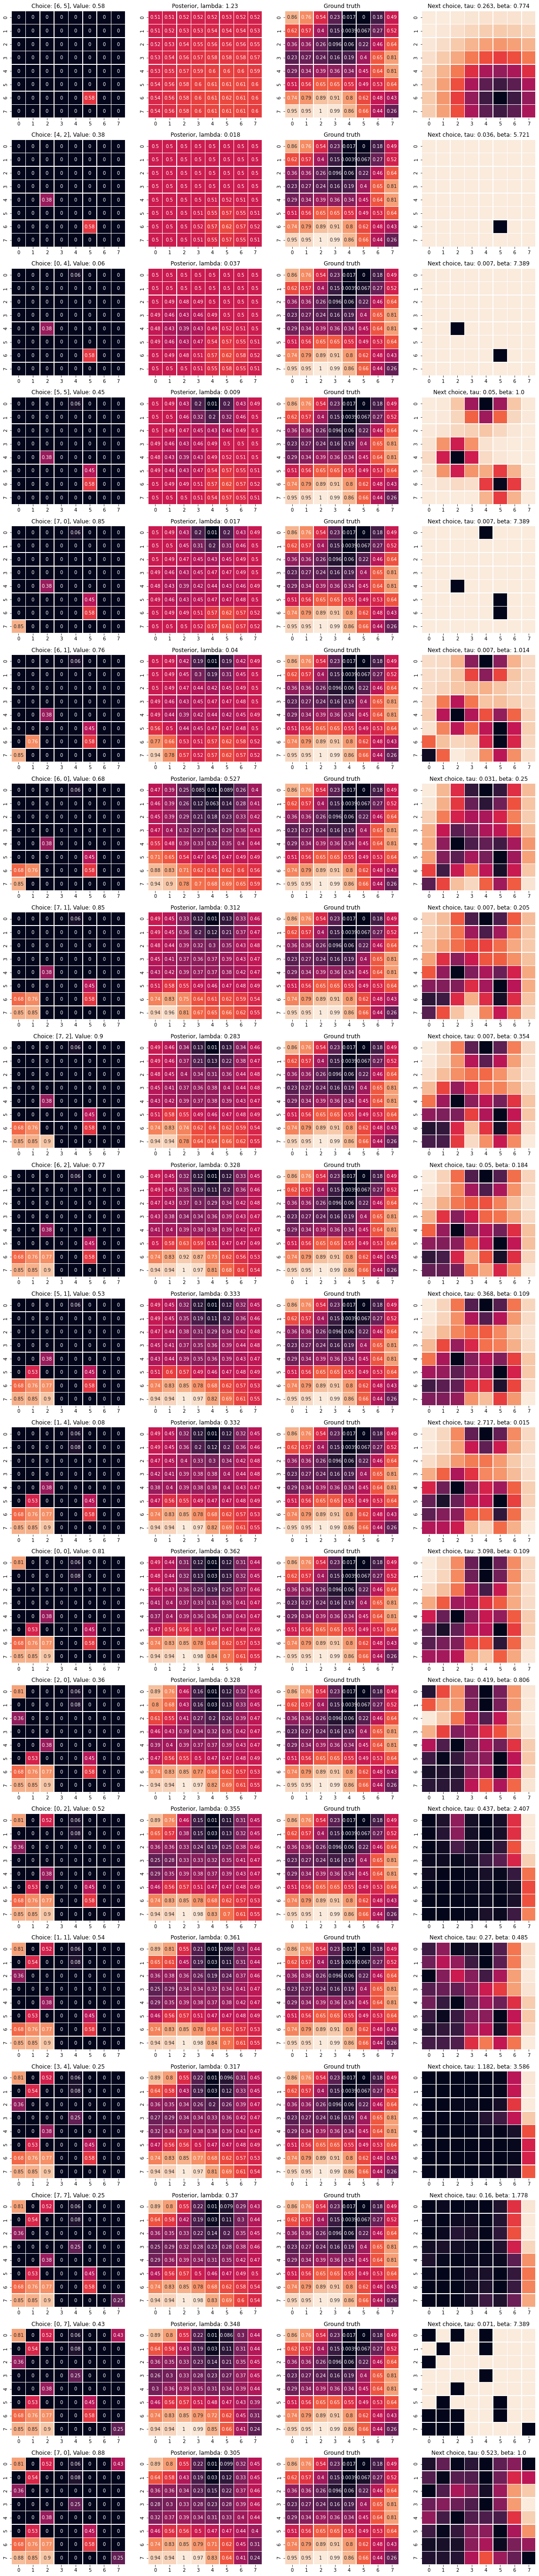

In [43]:
# Plots one round but takes a while because it will make 80 plots
choices = getChoices(df, 0, 0)
environment = getEnvironment(df, roughEnvironments, smoothEnvironments, 0, 0)
plotResults(choices, environment, out, parameters, p)

[0.07336737 0.00673795 0.34304136]


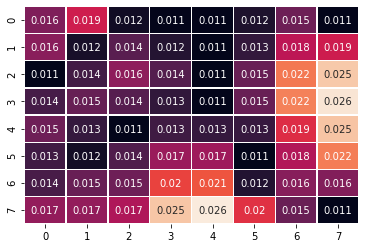

In [48]:
# Acquisition function
n = 19
print(parameters[0:3,n])
plotHeatmap(createArrayGP(p[n].tolist()), False)

[0.07336737 0.00673795 0.34304136]


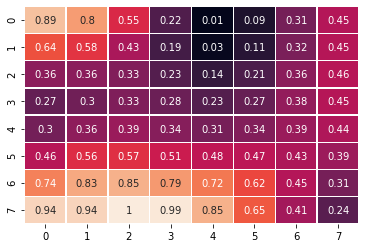

In [51]:
# Posterior
n = 19
print(parameters[0:3,n])
plotHeatmap(createArrayGP(out[n]["mu"])+0.5, False)

In [14]:
getAvgParam = lambda i: [sum(parameters[i,x*20 + y] for x in range(int(len(parameters[i,:])/20)))/(len(parameters[i,:])/20) for y in range(20)]

In [15]:
def plotLearningCurves(parameters):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(int(len(parameters[0,:])/20)):
        axes[0].plot(parameters[0,(i*20):((i+1)*20)])
        axes[1].plot(parameters[1,(i*20):((i+1)*20)])
        axes[2].plot(parameters[2,(i*20):((i+1)*20)])
    plt.plot()

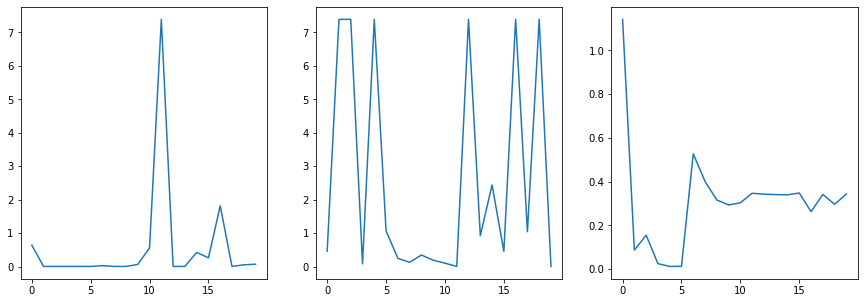

In [52]:
plotLearningCurves(parameters)

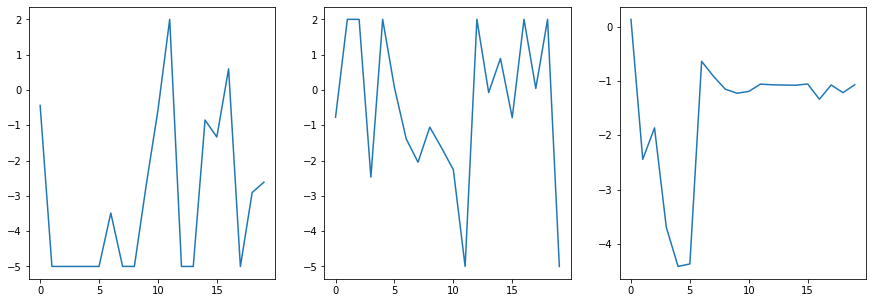

In [53]:
logPars = parameters
logPars[parameters <= 0] = 0.0001
logPars = np.log(logPars)
plotLearningCurves(np.log(parameters))

[]

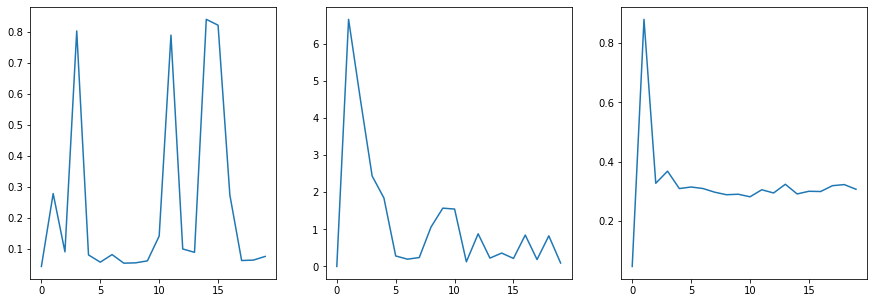

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# tau, beta, lambda
#axes[0].plot(np.log(getAvgParam(0)))
#axes[1].plot(np.log(getAvgParam(1)))
#axes[2].plot(np.log(getAvgParam(2)))

axes[0].plot(getAvgParam(0))
axes[1].plot(getAvgParam(1))
axes[2].plot(getAvgParam(2))
plt.plot()

In [2]:
def modelFit2(par, subjD, rounds, returnPredictions=False):
    tau = np.exp(float(par[0]))
    beta = np.exp(float(par[1]))
    lam = np.exp(float(par[2]))
    parVec = [lam, lam, 1, 0.0001]
    
    Xnew = [[x, y] for y in range(8) for x in range(8)]
    nLL = [0]*len(rounds)
    utilities = None
    for r in rounds:
        roundD = np.array(subjD["round"]) == r
        chosen = np.array(subjD["chosen"])[roundD]
        chosen = chosen[1:20]
        y = np.array(subjD["z"])[roundD]
        y = y[0:20]
        x1 = np.array(subjD["x"])[roundD]
        x1 = x1[0:20]
        x2 = np.array(subjD["y"])[roundD]
        x2 = x2[0:20]
        X = np.column_stack((x1,x2))

        utilities = None
        for i in range(19):
            X1 = np.matrix(X[0:i+1,:])
            y1 = np.matrix(y[0:i+1])
            out = gpr(Xnew, parVec, X1, y1, rbf)
            utilityVec = ucb(out, [beta])
            utilityVec = utilityVec - np.max(utilityVec)
            if i==0:
                utilities = utilityVec
            else:
                utilities = np.row_stack((utilities, utilityVec))
        p = np.exp(utilities / tau)
        p = p / np.sum(p, 1)
        p[p < 0.00001] = 0.00001
        p[p > 0.99999] = 0.99999
        a = [[x, chosen[x]] for x in range(19)]
        nLL[[x for x in range(len(rounds)) if rounds[x]==r][0]] = -np.sum(np.log([p[x[0], x[1]] for x in a]))
        #clear_output(wait=True)
        #print(str(r+1) + "/" + str(len(rounds)))
    if returnPredictions:
        return {"sumLogLoss": np.sum(nLL), "logLoss": nLL, "predictions": p, "chosen": chosen}
    else:
        return np.sum(nLL)
    
def modelFit(par, subjD, rounds, returnPredictions=False):
    tau = float(par["tau"])
    lam = float(par["lambda"])
    beta = float(par["beta"])
    return modelFit2([tau, beta, lam], subjD, rounds, returnPredictions)

In [5]:
# Test
modelFit2([0.953290334560277,0.14184440300399,0.0706500217485385], df.iloc[0], [x for x in range(10)], True)

{'sumLogLoss': 799.150157848398,
 'logLoss': [77.94201238620916,
  77.90895614419912,
  79.12634294743856,
  81.49228283699493,
  80.95498328569745,
  80.27099590754462,
  81.41172648118604,
  80.8629105337758,
  80.7651523736277,
  78.4147949517245],
 'predictions': matrix([[0.0158205 , 0.01576797, 0.0158205 , ..., 0.01584554, 0.01584554,
          0.01584554],
         [0.01585035, 0.01579773, 0.01585072, ..., 0.01587548, 0.01587549,
          0.01587548],
         [0.01596103, 0.01590803, 0.01596125, ..., 0.01598632, 0.01598634,
          0.01598634],
         ...,
         [0.01223846, 0.01663206, 0.01766317, ..., 0.01391364, 0.01389875,
          0.0139521 ],
         [0.01223773, 0.01663106, 0.01766211, ..., 0.01391282, 0.01391298,
          0.01395127],
         [0.01223902, 0.01663285, 0.01766402, ..., 0.01397269, 0.01391446,
          0.01395273]]),
 'chosen': array([22, 23, 12,  7, 29, 31, 33, 50,  0, 61, 60, 53, 62, 63, 44, 61, 62,
        61, 61])}

In [15]:
import scipy as scp

def rbf2(x1,x2,theta):
    N = np.shape(x1)[0]
    d = np.shape(x1)[1]
    sigma = np.matrix((np.subtract.outer(x1,x2)/theta[0])**2).T
    return theta[d]*np.exp(-0.5 * sigma) + theta[d+1]*np.identity(N)

def gpr_first(X_test, theta, X, Y, k):
    Xstar = np.matrix(X_test)
    K = k(X, X, theta)
    KK_inv = np.linalg.cholesky(K)
    Ky = KK_inv.dot(Y.T)
    mus = [0]*np.shape(Xstar)[0]
    sigs = [0]*np.shape(Xstar)[0]
    
    
    for i in range(np.shape(Xstar)[0]):
        XX = Xstar[i]
        Kstar = k(X, XX, theta)
        Kstarstar = k(XX,XX,theta)
        mu = Kstar.T.dot(Ky)
        cv = Kstarstar - (Kstar.T.dot(KK_inv).dot(Kstar))
        if cv < 0:
            cv = abs(cv)
        mus[i] = float(mu)
        sigs[i] = float(cv)
    return pd.DataFrame({"mu": mus, "sig": sigs}), K, KK_inv

def gpr_sequential(X_test, theta, X, Y, k, old_K, old_KK_inv):
    Xstar = np.matrix(X_test)
    K = k(X, X, theta)
    KK_inv = np.zeros([len(old_K[:,0])+1,len(old_K[:,0])+1])
    KK_inv[:-1,:-1] = old_KK_inv
    X1 = K[-1,:-1]
    X2 = K[-1,-1]
    a = scp.linalg.solve_triangular(old_KK_inv, X1.T)
    KK_inv[-1,:-1] = a.T
    print(a.T)
    print(X1.dot(np.linalg.inv(old_KK_inv).T))
    print(a.T.dot(a))
    print(isPositiveDefinite(X2 - a.T.dot(a)))
    KK_inv[-1,-1] = np.linalg.cholesky(X2 - a.T.dot(a))
    Ky = KK_inv.dot(Y.T)
    mus = [0]*np.shape(Xstar)[0]
    sigs = [0]*np.shape(Xstar)[0]
    
    
    for i in range(np.shape(Xstar)[0]):
        XX = Xstar[i]
        Kstar = k(X, XX, theta)
        Kstarstar = k(XX,XX,theta)
        mu = Kstar.T.dot(Ky)
        cv = Kstarstar - (Kstar.T.dot(KK_inv).dot(Kstar))
        if cv < 0:
            cv = abs(cv)
        mus[i] = float(mu)
        sigs[i] = float(cv)
    return pd.DataFrame({"mu": mus, "sig": sigs}), K, KK_inv

In [104]:
modelFit3([0.953290334560277,0.14184440300399,0.0706500217485385], df.iloc[0], [x for x in range(10)], False)

[[0.00354032]]
[[0.00354032]]
[[1.25338953e-05]]
True
[[1.05740044e-07 1.69555306e-04]]
[[1.05740044e-07 1.69554932e-04]]
[[2.87490131e-08]]
True
[[6.47805760e-01 1.30210557e-02 1.25345222e-05]]
[[6.47805760e-01 1.07277136e-02 1.06471768e-05]]
[[0.41982185]]
True
[[1.25345220e-05 3.54034637e-03 5.56290984e-13 4.47415411e-06]]
[[ 1.25345220e-05  3.54030200e-03 -6.00247756e-07 -6.67010251e-05]]
[[1.25342296e-05]]
True
[[9.62592755e-04 1.14107345e-01 3.28073871e-09 8.18677232e-04
  4.19675915e-01]]
[[ 9.62592755e-04  1.14103938e-01 -1.93427822e-05 -1.95034042e-03
   4.19271962e-01]]
[[0.18914996]]
True
[[1.93482308e-05 3.10250978e-02 1.57122100e-10 1.64555114e-05
  6.47809820e-01 7.19398401e-01]]
[[ 1.93482308e-05  3.10250293e-02 -5.26004034e-06 -5.30321055e-04
   6.47699987e-01  4.13617836e-01]]
[[0.93815418]]
True
[[6.23604309e-04 1.30210557e-02 1.16154593e-11 2.22593393e-04
  6.47809820e-01 7.19398401e-01 1.68626968e+00]]
[[ 6.23604309e-04  1.30188480e-02 -2.20735876e-06 -5.30260071e-0

LinAlgError: Matrix is not positive definite

In [22]:
gpr([[x2, x1] for x1 in range(8) for x2 in range(8)], [0.945098951166948, 0.945098951166948, 1, 0.0001], np.matrix([4,1]), np.matrix([-0.1577524891006599]), rbf)

,mu,sig
0,-1.161695e-05,1.000100
1,-5.845881e-04,1.000086
2,-9.602656e-03,0.996394
3,-5.148921e-02,0.893557
4,-9.012069e-02,0.673708
...,...,...
59,-1.595609e-10,1.000100
60,-2.792767e-10,1.000100
61,-1.595609e-10,1.000100
62,-2.975785e-11,1.000100


In [23]:
gpr([[x2, x1] for x1 in range(8) for x2 in range(8)], [0.945098951166948, 0.945098951166948, 1, 0.0001], np.column_stack(([4,1], [5,1])), np.matrix([-0.1577524891006599,-0.1577524891006599]), rbf)

,mu,sig
0,-0.051489,0.893557
1,-0.090121,0.673708
2,-0.051489,0.893557
3,-0.009603,0.996394
4,-0.000585,1.000086
...,...,...
59,-0.009603,0.996394
60,-0.016807,0.988748
61,-0.009603,0.996394
62,-0.001791,0.999971


In [38]:
gpr2([[x2, x1] for x1 in range(8) for x2 in range(8)], [0.945098951166948, 0.945098951166948, 1, 0.0001], np.column_stack(([4,1], [5,1])), np.matrix([-0.1577524891006599,-0.1577524891006599]), rbf, np.matrix([[1.0001]]), np.matrix([[0.99990001]]))

(              mu       sig
 0  -5.149693e-02  0.893541
 1  -9.013421e-02  0.673659
 2  -5.149693e-02  0.893541
 3  -9.604097e-03  0.996394
 4  -5.846758e-04  1.000086
 ..           ...       ...
 59 -2.976231e-11  1.000100
 60 -1.811863e-12  1.000100
 61 -3.600537e-14  1.000100
 62 -2.335569e-16  1.000100
 63 -4.945403e-19  1.000100
 
 [64 rows x 2 columns],
 matrix([[1.00010000e+00, 8.36166886e-07],
         [8.36166886e-07, 1.00010000e+00]]),
 array([[0.     , 0.     ],
        [0.     , 1.00005]]))

In [24]:
from timeit import default_timer as timer
start = timer()
for i in range(20):
    gpr([[x2, x1] for x1 in range(8) for x2 in range(8)], [0.945098951166948, 0.945098951166948, 1, 0.0001], np.column_stack(([4,1], [5,1])), np.matrix([-0.1577524891006599,-0.1577524891006599]), rbf)
end = timer()
print(end-start)

0.49409485700016376


In [16]:
gpr([[x2, x1] for x1 in range(8) for x2 in range(8)], [0.945098951166948, 0.945098951166948, 1, 0.0001], np.column_stack(([4,1], [5,1])), np.matrix([-0.1577524891006599,-0.1577524891006599]), rbf)

,mu,sig
0,-0.051489,0.893557
1,-0.090121,0.673708
2,-0.051489,0.893557
3,-0.009603,0.996394
4,-0.000585,1.000086
...,...,...
59,-0.009603,0.996394
60,-0.016807,0.988748
61,-0.009603,0.996394
62,-0.001791,0.999971


In [50]:
ucb(gpr([[x2, x1] for x1 in range(8) for x2 in range(8)], [0.945098951166948, 0.945098951166948, 1, 0.0001], np.column_stack(([4,1], [5,1])), np.matrix([-0.1577524891006599,-0.1577524891006599]), rbf), [0.5])

matrix([[4.21151648e-01, 3.20277855e-01, 4.21151634e-01, 4.89495030e-01,
         4.99436847e-01, 5.00013306e-01, 5.00024910e-01, 5.00024998e-01,
         3.20277853e-01, 1.00000000e-04, 3.20275689e-01, 4.80359954e-01,
         4.98970951e-01, 4.99993044e-01, 5.00022701e-01, 5.00024867e-01,
         4.21151516e-01, 3.20271218e-01, 4.21042497e-01, 4.88907078e-01,
         4.98403267e-01, 4.99425360e-01, 4.99915780e-01, 5.00018362e-01,
         4.89492939e-01, 4.80262427e-01, 4.87671945e-01, 4.87671945e-01,
         4.80262427e-01, 4.89492939e-01, 4.98201884e-01, 4.99915855e-01,
         4.99425360e-01, 4.98403267e-01, 4.88907078e-01, 4.21042497e-01,
         3.20271218e-01, 4.21151516e-01, 4.89495104e-01, 4.99436978e-01,
         4.99993044e-01, 4.98970951e-01, 4.80359954e-01, 3.20275689e-01,
         1.00000000e-04, 3.20277853e-01, 4.80371572e-01, 4.98991288e-01,
         5.00013306e-01, 4.99436847e-01, 4.89495030e-01, 4.21151634e-01,
         3.20277855e-01, 4.21151648e-01, 4.89495105

In [51]:
f = open("experiment/roughEnvironment.json")
roughEnvironments = json.load(f)
f.close()
f = open("experiment/smoothEnvironment.json")
smoothEnvironments = json.load(f)
f.close()

gpPars = pd.read_csv("rationalModels/parameters/gpucb.csv", sep=",")

In [58]:
def modelFit3(par, subjD, rounds, returnPredictions=False):
    tau = np.exp(float(par[0]))
    beta = np.exp(float(par[1]))
    lam = np.exp(float(par[2]))
    parVec = [lam, lam, 1, 0.0001]
    
    Xnew = [[x, y] for y in range(8) for x in range(8)]
    nLL = [0]*len(rounds)
    utilities = None
    for r in rounds:
        roundD = np.array(subjD["round"]) == r
        chosen = np.array(subjD["chosen"])[roundD]
        chosen = chosen[1:20]
        y = np.array(subjD["z"])[roundD]
        y = y[0:20]
        x1 = np.array(subjD["x"])[roundD]
        x1 = x1[0:20]
        x2 = np.array(subjD["y"])[roundD]
        x2 = x2[0:20]
        X = np.column_stack((x1,x2))

        X1 = np.matrix(X[0:1,:])
        y1 = np.matrix(y[0:1])
        out, old_K, old_KK_inv = gpr_first(Xnew, parVec, X1, y1, rbf)
        utilityVec = ucb(out, [beta])
        utilityVec = utilityVec - np.max(utilityVec)
        utilities = utilityVec
        for i in range(18):
            X1 = np.matrix(X[0:i+2,:])
            y1 = np.matrix(y[0:i+2])
            out, old_K, old_KK_inv = gpr_sequential(Xnew, parVec, X1, y1, rbf, old_K, old_KK_inv)
            utilityVec = ucb(out, [beta])
            utilityVec = utilityVec - np.max(utilityVec)
            utilities = np.row_stack((utilities, utilityVec))
        p = np.exp(utilities / tau)
        p = p / np.sum(p, 1)
        p[p < 0.00001] = 0.00001
        p[p > 0.99999] = 0.99999
        a = [[x, chosen[x]] for x in range(19)]
        nLL[[x for x in range(len(rounds)) if rounds[x]==r][0]] = -np.sum(np.log([p[x[0], x[1]] for x in a]))
        #clear_output(wait=True)
        #print(str(r+1) + "/" + str(len(rounds)))
    if returnPredictions:
        return {"sumLogLoss": np.sum(nLL), "predictions": p, "chosen": chosen}
    else:
        return np.sum(nLL)

In [56]:
# Test
modelFit2([0.953290334560277,0.14184440300399,0.0706500217485385], df.iloc[0], [x for x in range(10)], False)

799.150157848398

In [86]:
modelFit3([0.953290334560277,0.14184440300399,0.0706500217485385], df.iloc[0], [x for x in range(10)], False)

1.0001
[[0.00354032]]
1.0001
[[1.05740044e-07]
 [1.69555306e-04]]
1.0001
[[6.47805760e-01]
 [1.30210557e-02]
 [1.25345222e-05]]
1.0001
[[1.25345220e-05]
 [3.54034637e-03]
 [5.56290984e-13]
 [4.47415411e-06]]
1.0001
[[9.62592755e-04]
 [1.14107345e-01]
 [3.28073871e-09]
 [8.18677232e-04]
 [4.19675915e-01]]
1.0001
[[1.93482308e-05]
 [3.10250978e-02]
 [1.57122100e-10]
 [1.64555114e-05]
 [6.47809820e-01]
 [7.19398401e-01]]
1.0001
[[6.23604309e-04]
 [1.30210557e-02]
 [1.16154593e-11]
 [2.22593393e-04]
 [6.47809820e-01]
 [7.19398401e-01]
 [1.68626968e+00]]


LinAlgError: Matrix is not positive definite

In [24]:
start = timer()
print(modelFit2([1,  0.5, 1], df.iloc[0], range(10), False))
end = timer()
print(end - start)

791.7647075470223
7.741365010999999


In [25]:
import scipy.optimize as sco

def cvfunc(data, task, selector, leaveoutindex):
    d1 = [data.iloc[x] for x in range(len(data)) if data.iloc[x]["id"][0] == selector][0].copy()
    b = [d1["context"][x]==task for x in range(len(d1["context"]))]
    for i in range(len(d1)):
        d1[i] = [d1[i][x] for x in range(len(d1[i])) if b[x]]
        
    rounds = [x for x in range(9)]
    trainingSet = [rounds[x] for x in range(len(rounds)) if x != leaveoutindex]
    testSet = rounds[leaveoutindex]
    bounds = [(-5,5),(-5,5),(-5,5)]
    fit = sco.differential_evolution(modelFit2, bounds, (d1, trainingSet, False), disp=True, maxiter=20)
    paramEstimates = fit.x
    print(fit)
    
    
    predict = modelFit2(paramEstimates, d1, [testSet], True)
    cvresults = {"loo": leaveoutindex, "nLL": predict["sumLogLoss"], "tau": paramEstimates[0], "lambda": paramEstimates[1], "beta": paramEstimates[2]}
    return [cvresults, predict["predictions"], predict["chosen"]]

In [26]:
# For testing purposes
def modelFit3(data, pars, task, selector, leaveoutindex):
    d1 = [data.iloc[x] for x in range(len(data)) if data.iloc[x]["id"][0] == selector][0].copy()
    b = [d1["context"][x]==task for x in range(len(d1["context"]))]
    for i in range(len(d1)):
        d1[i] = [d1[i][x] for x in range(len(d1[i])) if b[x]]
    
    rounds = [x for x in range(9)]
    trainingSet = [rounds[x] for x in range(len(rounds)) if x != leaveoutindex]
    print(modelFit2(pars, d1, trainingSet, False))

In [27]:
modelFit3(df, [1.02320515632445,0.110314130468726,0.0676485720434532], "Spatial", 1, 0)

641.2145678759513


In [36]:
import cma

def cvfunc2(data, task, selector, leaveoutindex):
    d1 = [data.iloc[x] for x in range(len(data)) if data.iloc[x]["id"][0] == selector][0].copy()
    b = [d1["context"][x]==task for x in range(len(d1["context"]))]
    for i in range(len(d1)):
        d1[i] = [d1[i][x] for x in range(len(d1[i])) if b[x]]
        
    rounds = [x for x in range(9)]
    trainingSet = [rounds[x] for x in range(len(rounds)) if x != leaveoutindex]
    testSet = rounds[leaveoutindex]
    #bounds = [(-5,5),(-5,5),(-5,5)]
    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-3)
    es = cma.CMAEvolutionStrategy(3 * [0], 2.5, opts)
    es.optimize(lambda pars: modelFit2(pars, d1, trainingSet, False))
    es.result_pretty()
    
    #paramEstimates = fit.x
    
    
    #predict = modelFit2(paramEstimates, d1, [testSet], True)
    #cvresults = {"loo": leaveoutindex, "nLL": predict["sumLogLoss"], "tau": paramEstimates[0], "lambda": paramEstimates[1], "beta": paramEstimates[2]}
    #return [cvresults, predict["predictions"], predict["chosen"]]

In [ ]:
start = timer()
cv = cvfunc2(df, "Spatial", 1, 0)
end = timer()
print(end - start)

(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=168175, Tue Nov 16 08:21:31 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 5.900832292311934e+02 1.0e+00 2.72e+00  3e+00  3e+00 0:26.5
    2     14 4.759448511338443e+02 1.7e+00 2.42e+00  2e+00  3e+00 0:52.1
    3     21 5.543772920460609e+02 1.7e+00 2.44e+00  2e+00  3e+00 1:20.2
    4     28 5.141549414573842e+02 1.8e+00 2.75e+00  2e+00  4e+00 1:48.2
    5     35 4.756576874456733e+02 2.2e+00 2.62e+00  1e+00  4e+00 2:15.9
    6     42 4.871415283084703e+02 2.9e+00 2.64e+00  1e+00  4e+00 2:43.1
    7     49 4.752017388009087e+02 3.2e+00 2.84e+00  1e+00  4e+00 3:11.9
    8     56 4.060568422934689e+02 3.7e+00 2.68e+00  1e+00  4e+00 3:39.8
    9     63 4.098057393024183e+02 4.0e+00 2.45e+00  8e-01  3e+00 4:06.3
   10     70 3.977212806429038e+02 5.0e+00 2.63e+00  7e-01  3e+00 4:33.1
   11     77 4.727463904854616e+02 5.2e+00 2.27e+00  6e-01  3e+00 5:00.9
   12     84 4.543398300698667e+02 

In [34]:
start = timer()
cv = cvfunc(df, "Spatial", 1, 0)
end = timer()
print(end - start)

differential_evolution step 1: f(x)= 422.388
differential_evolution step 2: f(x)= 401.834
differential_evolution step 3: f(x)= 401.834
differential_evolution step 4: f(x)= 401.834
differential_evolution step 5: f(x)= 386.899
differential_evolution step 6: f(x)= 384.805
differential_evolution step 7: f(x)= 384.805
differential_evolution step 8: f(x)= 380.769
differential_evolution step 9: f(x)= 380.769
differential_evolution step 10: f(x)= 380.769
differential_evolution step 11: f(x)= 380.769
differential_evolution step 12: f(x)= 380.769
differential_evolution step 13: f(x)= 380.769
     fun: 380.741058209749
     jac: array([0.11732482, 0.04566232, 0.19019808])
 message: 'Optimization terminated successfully.'
    nfev: 762
     nit: 13
 success: True
       x: array([-2.6929985 , -2.20447288,  0.02291427])
2967.131356516


In [35]:
# Same result as in the original paper
np.exp([-2.6929985 , -2.20447288,  0.02291427])

array([0.0676777 , 0.11030866, 1.02317882])

In [65]:
# Cross validation
start = timer()

crossvalidation = [0]*9
modelPrediction = [np.zeros((19,64)) for x in range(9)]
chosenMatrix = np.zeros((9,19))

print("0/9")
for loo in range(9):
    cv = cvfunc(data=df, task="Conceptual", selector = 1, leaveoutindex=loo)
    crossvalidation[loo] = cv[0]
    modelPrediction[loo] = cv[1]
    chosenMatrix[loo,:] = cv[2]
    clear_output(wait=True)
    print(str(loo+1) + "/9")
end = timer()
print(end - start)

9/9
14024.757741057998


In [66]:
print(crossvalidation)

[{'loo': 0, 'nLL': 64.69578615321979, 'tau': -1.7359799346259148, 'lambda': 1.2526199792066952, 'beta': 2.816470433741199}, {'loo': 1, 'nLL': 53.25192536013484, 'tau': -1.514800608581477, 'lambda': 1.0510893139426847, 'beta': -1.5199827375408197}, {'loo': 2, 'nLL': 53.63567414607466, 'tau': -1.4809955471101384, 'lambda': 1.0289185606200715, 'beta': 0.3203988646542033}, {'loo': 3, 'nLL': 54.106591870775375, 'tau': -1.4681311857985988, 'lambda': 1.0472333021121056, 'beta': 0.11875721084958935}, {'loo': 4, 'nLL': 51.62553544067555, 'tau': -1.4442281513708581, 'lambda': 0.9718984196096366, 'beta': 2.490497801174365}, {'loo': 5, 'nLL': 55.648868256320476, 'tau': -1.508485452508975, 'lambda': 1.044129880935834, 'beta': -1.393809405923524}, {'loo': 6, 'nLL': 52.444721066050434, 'tau': -1.462763140519846, 'lambda': 1.0472344877805342, 'beta': -2.464177746122756}, {'loo': 7, 'nLL': 50.860244403557935, 'tau': -1.4286421661134918, 'lambda': 1.047241242497942, 'beta': -3.3774076254259127}, {'loo':